## Labeling Data using Non supervised ML 

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from bayes_opt import BayesianOptimization
import time
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [9]:
def best_f1_score(y_true, y_pred):
    # Calcul du F1-score dans l'ordre actuel
    f1_1 = f1_score(y_true, y_pred, average='weighted')
    # Inverser les labels (pour cas binaire)
    y_pred_swapped = np.where(y_pred == 0, 1, 0) 
    f1_2 = f1_score(y_true, y_pred_swapped, average='weighted')
    return max(f1_1, f1_2)

In [28]:
data5 = pd.read_csv('Data_Preprocessed1/data_5.csv')
df = data5.copy()
X = df.drop(columns=['label', 'start_index', 'end_index'])
y_true = df['label'].values
X

,mean_ax,mean_ay,mean_az,rms_ax,rms_ay,rms_az,std_ax,std_ay,std_az,smv_mean,...,smv_min,iqr_ax,iqr_ay,iqr_az,max_min_ax,max_min_ay,max_min_az,mean_freq_power_ax,mean_freq_power_ay,mean_freq_power_az
0,-0.216585,0.110633,-0.113081,1.475196,2.620018,2.391921,1.459211,2.617681,2.389246,3.738918,...,1.633137,2.165656,4.901595,4.723482,6.23199,9.48863,7.10265,8.377972,13.468801,11.568485
1,-0.287643,0.075782,-0.014178,1.502612,2.619767,2.404340,1.474824,2.618670,2.404298,3.760874,...,1.633137,2.195759,4.901595,4.828923,6.23199,9.48863,7.10265,7.604498,13.370296,10.847308
2,-0.310062,0.052404,0.029160,1.542809,2.635361,2.471098,1.511331,2.634840,2.470926,3.814201,...,1.633137,2.195759,5.014980,4.828923,6.23199,9.48863,8.32650,7.820560,13.302223,10.847289
3,-0.321828,0.066494,0.047563,1.557620,2.618419,2.501259,1.524010,2.617575,2.500806,3.823838,...,1.633137,2.195759,5.014980,4.828923,6.23199,9.48863,8.32650,7.828265,13.302610,10.954479
4,-0.353778,0.077475,0.063074,1.556291,2.603967,2.517724,1.515547,2.602814,2.516934,3.824178,...,1.633137,2.147496,5.014980,4.876398,6.23199,9.48863,8.32650,7.700128,13.229233,11.135828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11479,-0.207193,0.368179,-0.464894,0.949547,2.132930,3.518317,0.926666,2.100912,3.487468,3.679031,...,0.628075,1.033128,2.890189,5.257180,4.11356,8.09194,12.96239,5.755186,8.432153,15.217674
11480,-0.180569,0.318992,-0.487850,0.915061,2.190831,3.481939,0.897068,2.167484,3.447593,3.673671,...,0.628075,0.957839,2.890189,5.257180,4.11356,8.32239,12.96239,5.561137,8.501247,15.235348
11481,-0.182539,0.359503,-0.538822,0.917209,2.160372,3.429242,0.898861,2.130250,3.386646,3.613617,...,0.628075,0.957839,2.749607,5.257180,4.11356,8.32239,12.96239,5.577449,8.806743,15.054849
11482,-0.155767,0.450356,-0.683570,0.917631,2.161447,3.420840,0.904314,2.114009,3.351847,3.607592,...,0.628075,0.951634,2.876117,5.038170,4.11356,8.32239,12.96239,5.709186,9.130498,16.044074


## Finding Best Parameters

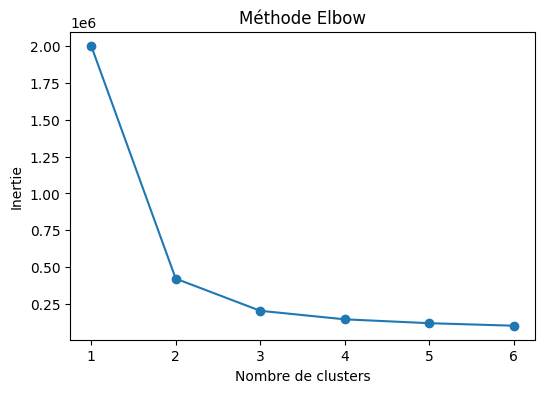

In [29]:
inertias = []
cluster_range = range(1, 7)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Visualisation de la méthode Elbow
plt.figure(figsize=(6,4))
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode Elbow')
plt.show()

In [33]:
def my_KMeans(n_clusters, max_iter):
    n_clusters = int(n_clusters)  
    max_iter = int(max_iter)  
    
    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, init='k-means++', random_state=0)  
    labels = kmeans.fit_predict(X)

    # Calcul du score de silhouette (plus haut est meilleur)
    score = silhouette_score(X, labels)
    return score  # BayesianOptimization maximise la fonction

# Définition des hyperparamètres à optimiser
pbounds = {'n_clusters': (2, 5), 'max_iter': (100, 500)}

# Initialisation de l'optimisation bayésienne
optimizer = BayesianOptimization(f=my_KMeans, pbounds=pbounds, random_state=1)

# Exécution de l'optimisation
start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()

# Affichage des meilleurs hyperparamètres trouvés
print("Temps d'optimisation :", end - start)
print("Meilleurs paramètres :", optimizer.max)

|   iter    |  target   | max_iter  | n_clus... |
-------------------------------------------------
| 1         | 0.5163    | 266.8     | 4.161     |
| 2         | 0.662     | 100.0     | 2.907     |
| 3         | 0.662     | 158.7     | 2.277     |
| 4         | 0.5956    | 174.5     | 3.037     |
| 5         | 0.5956    | 258.7     | 3.616     |
| 6         | 0.5163    | 267.7     | 4.056     |
| 7         | 0.5163    | 181.8     | 4.634     |
| 8         | 0.5163    | 111.0     | 4.011     |
| 9         | 0.5956    | 266.9     | 3.676     |
| 10        | 0.662     | 156.2     | 2.594     |
| 11        | 0.5956    | 143.5     | 3.107     |
| 12        | 0.5956    | 432.0     | 3.98      |
| 13        | 0.5163    | 432.0     | 4.033     |
| 14        | 0.5163    | 134.4     | 4.276     |
| 15        | 0.662     | 258.3     | 2.484     |
| 16        | 0.5956    | 455.1     | 3.342     |
| 17        | 0.5956    | 272.9     | 3.056     |
| 18        | 0.5956    | 344.0     | 3.179     |


In [30]:
optimal_clusters = 2

# Entraîner le modèle KMeans avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=100, random_state=42)
y_pred = kmeans.fit_predict(X)

# Calculer le score de silhouette 
sil_score = silhouette_score(X, y_pred)

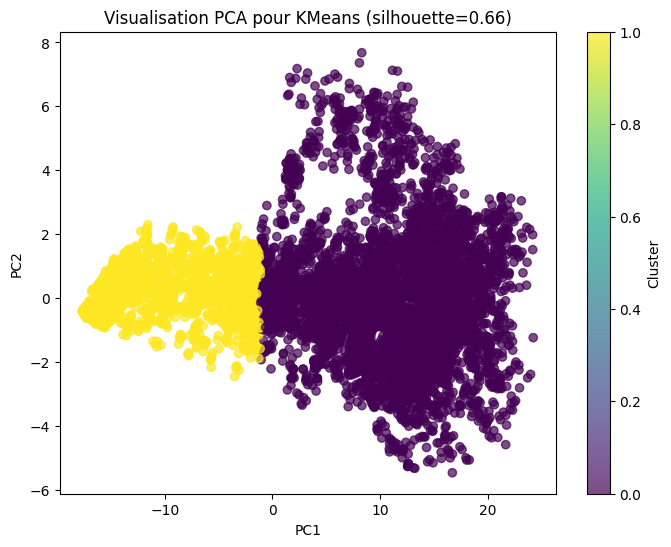

In [31]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
plt.title(f"Visualisation PCA pour KMeans (silhouette={sil_score:.2f})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [43]:
score = best_f1_score(y_true, y_pred)
print(f"F1-score pour le patient 5 : {score:.4f}\n")

F1-score pour le patient 5 : 0.8891




Traitement de Data_Preprocessed1\data_1.csv...

Traitement de Data_Preprocessed1\data_2.csv...

Traitement de Data_Preprocessed1\data_3.csv...

Traitement de Data_Preprocessed1\data_4.csv...

Traitement de Data_Preprocessed1\data_5.csv...


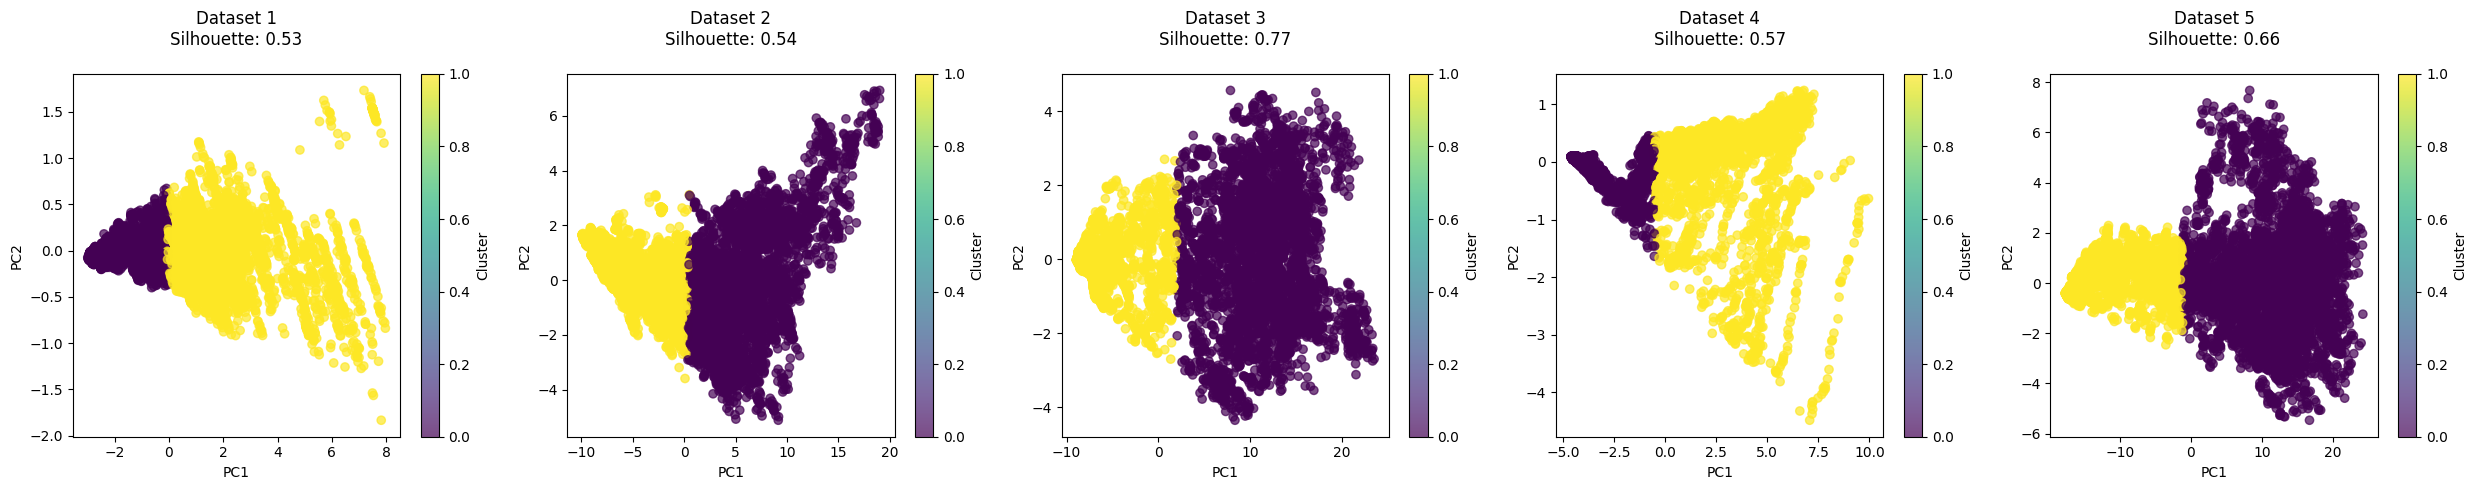

In [37]:
# Dossier contenant les fichiers
data_folder = "Data_Preprocessed1"
# Liste des fichiers (data_1.csv à data_5.csv)
file_list = [os.path.join(data_folder, f"data_{i}.csv") for i in range(1, 6)]

# Création d'une figure avec 5 sous-graphes (un pour chaque dataset)
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# Boucle sur chaque fichier
for idx, file in enumerate(file_list):
    print(f"\nTraitement de {file}...")
    # Charger le fichier
    df = pd.read_csv(file)
    
    # Supprimer les colonnes 'start_index' et 'end_index' si elles existent
    for col in ['start_index', 'end_index']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    
    # Séparation des features et du label
    X = df.drop(columns=['label'])
    y_true = df['label'].values

    # -------------------------------
    # Optimisation bayésienne pour KMeans
    # -------------------------------
    def my_KMeans(n_clusters, max_iter):
        # Conversion en entier
        n_clusters = int(n_clusters)
        max_iter = int(max_iter)
        kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, init='k-means++', random_state=0)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        return score  # La fonction retourne le score de silhouette à maximiser
    
    # -------------------------------
    # Clustering avec KMeans optimisé
    # -------------------------------
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100, random_state=42)
    y_pred = kmeans.fit_predict(X)
    sil_score = silhouette_score(X, y_pred)
    
    # -------------------------------
    # Réduction de dimension par PCA et Visualisation
    # -------------------------------
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    ax = axs[idx]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    ax.set_title(f"Dataset {idx+1}\nSilhouette: {sil_score:.2f}\n")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    fig.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.show()

## acceleration

In [9]:
df = pd.read_excel("Data/5.xlsx")
df.dropna(inplace=True)

# Sélectionner uniquement la colonne 'ax'
X = df[['ax']]
X = abs(X)
true_labels = df['lx']

In [10]:
# optimisation bayésienne
def my_kmeans(n_clusters, max_iter):
    n_clusters = int(n_clusters)
    max_iter = int(max_iter)
    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, init='k-means++', random_state=0)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

pbounds = {'n_clusters': (2, 5), 'max_iter': (100, 500)}
optimizer = BayesianOptimization(f=my_kmeans, pbounds=pbounds, random_state=0)
start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print("Temps d'optimisation :", end - start)
print("Meilleurs paramètres :", optimizer.max)

|   iter    |  target   | max_iter  | n_clus... |
-------------------------------------------------
| 1         | 0.6428    | 319.5     | 4.146     |
| 2         | 0.6648    | 341.1     | 3.635     |
| 3         | 0.6648    | 269.5     | 3.938     |
| 4         | 0.6428    | 275.0     | 4.675     |
| 5         | 0.6648    | 485.5     | 3.15      |
| 6         | 0.6648    | 416.7     | 3.587     |
| 7         | 0.6428    | 327.2     | 4.777     |
| 8         | 0.7234    | 128.4     | 2.261     |
| 9         | 0.6428    | 108.1     | 4.498     |
| 10        | 0.6428    | 411.3     | 4.61      |
| 11        | 0.7234    | 132.1     | 2.898     |
| 12        | 0.7234    | 143.9     | 2.265     |
| 13        | 0.6428    | 158.7     | 4.638     |
| 14        | 0.6428    | 139.7     | 4.976     |
| 15        | 0.6428    | 130.0     | 4.797     |
| 16        | 0.6648    | 367.5     | 3.592     |
| 17        | 0.6428    | 171.1     | 4.762     |
| 18        | 0.6428    | 132.6     | 4.443     |


Silhouette Score: 0.723


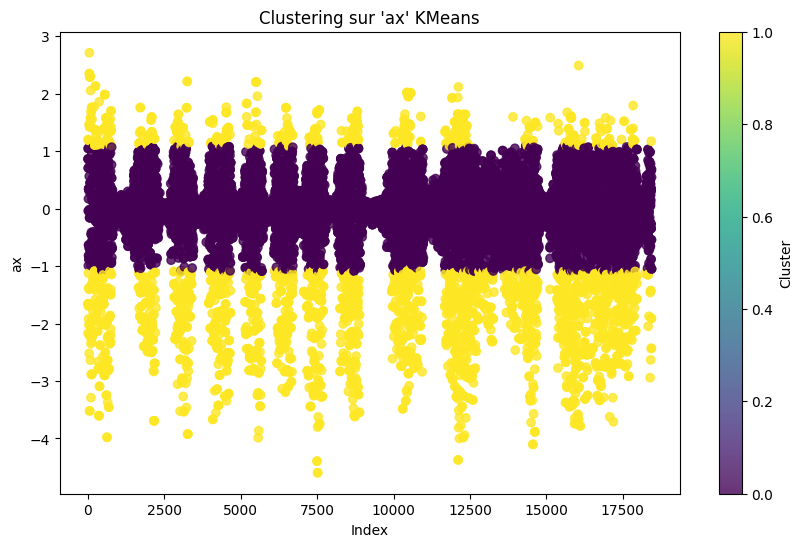

In [14]:
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=100, random_state=42)
predicted_labels = kmeans.fit_predict(X)

# Calculer le score de silhouette pour info
sil_score = silhouette_score(X, predicted_labels)
print(f"Silhouette Score: {sil_score:.3f}")

plt.figure(figsize=(10,6))
plt.scatter(df.index, df['ax'], c=predicted_labels, cmap='viridis', alpha=0.8)
plt.title("Clustering sur 'ax' KMeans")
plt.xlabel("Index")
plt.ylabel("ax")
plt.colorbar(label="Cluster")
plt.show()

In [15]:
f1_original = f1_score(true_labels, predicted_labels, average='weighted')
f1_swapped = f1_score(true_labels, 1 - predicted_labels, average='weighted')
f1_final = max(f1_original, f1_swapped)
print(f"F1-score: {f1_final:.3f}")

F1-score: 0.456


## Gaussian Mixtures Model

Processing Patient 1...


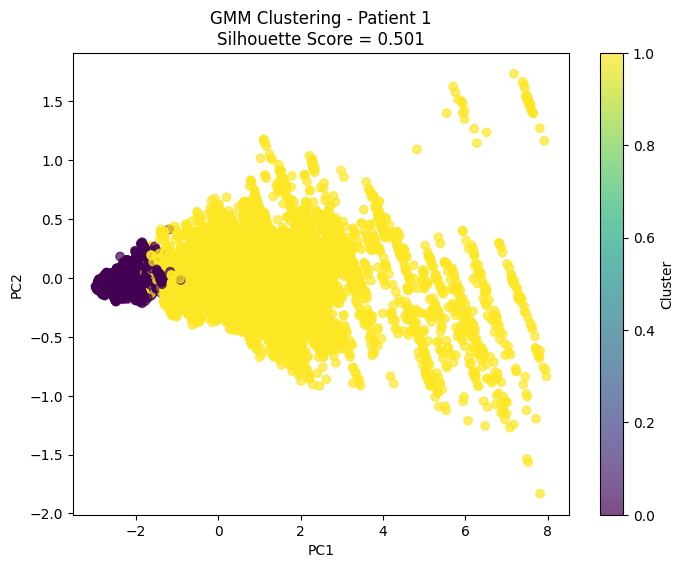

Patient 1 - Silhouette Score: 0.501
Processing Patient 2...


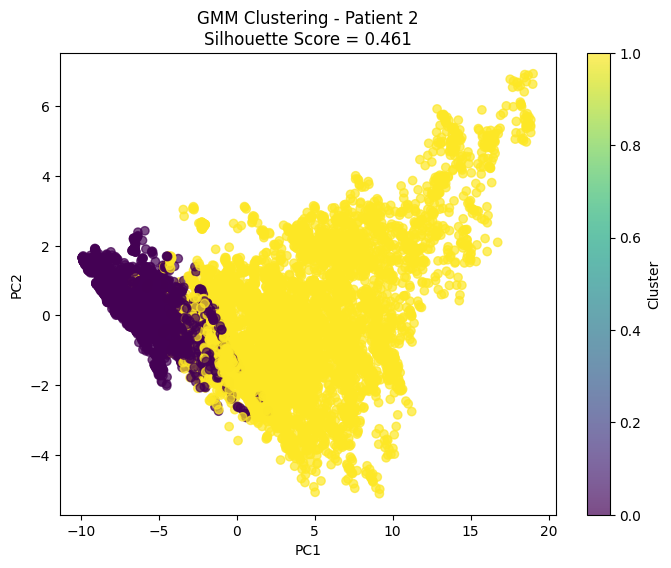

Patient 2 - Silhouette Score: 0.461
Processing Patient 3...


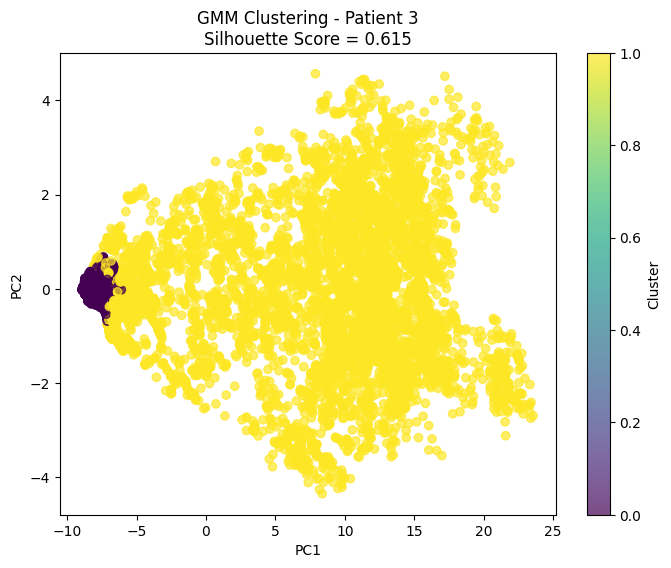

Patient 3 - Silhouette Score: 0.615
Processing Patient 4...


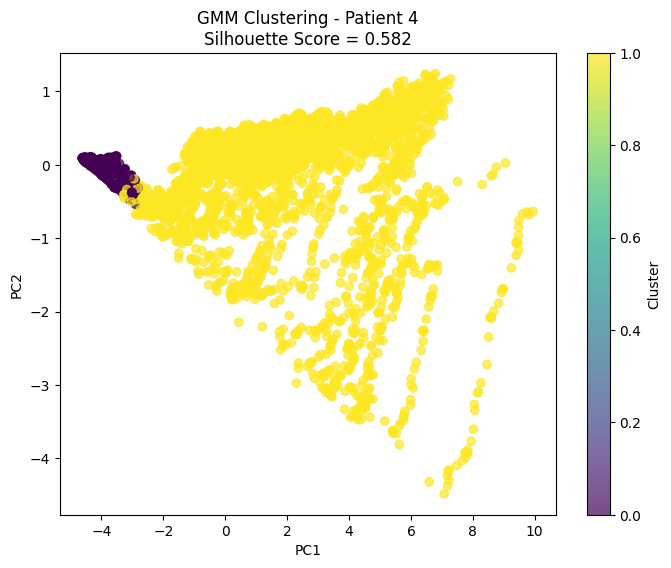

Patient 4 - Silhouette Score: 0.582
Processing Patient 5...


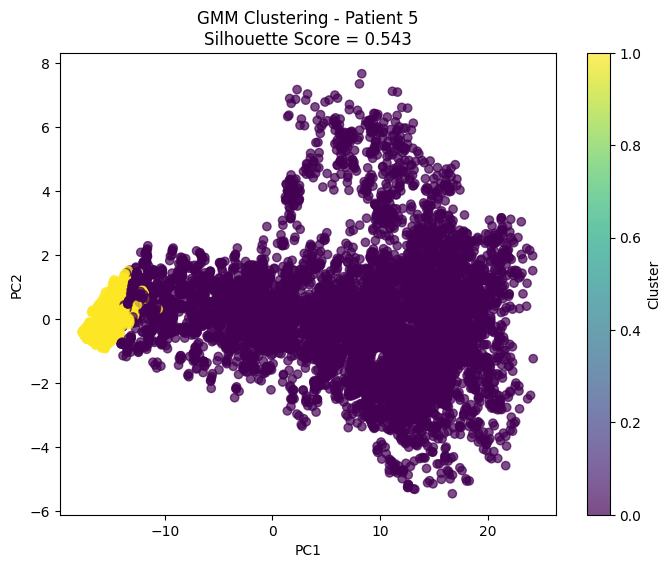

Patient 5 - Silhouette Score: 0.543
Results Summary:
Patient 1 - Silhouette Score: 0.501
Patient 2 - Silhouette Score: 0.461
Patient 3 - Silhouette Score: 0.615
Patient 4 - Silhouette Score: 0.582
Patient 5 - Silhouette Score: 0.543


In [ ]:
data_folder = "Data_Preprocessed1"
file_list = [os.path.join(data_folder, f"data_{i}.csv") for i in range(1, 6)]  # Files: data_1.csv to data_5.csv

# Iterate through each dataset (each patient)
results = {}
for file in file_list:
    patient_id = os.path.basename(file).split("_")[1].split(".")[0]  # Extract patient number
    print(f"Processing Patient {patient_id}...")

    # Load dataset
    df = pd.read_csv(file)

    # Remove unnecessary columns
    df.drop(columns=['start_index', 'end_index'], inplace=True)

    # Separate features and labels
    X = df.drop(columns=['label'])
    y_true = df['label'].values  # Real labels (for comparison)

    # Apply Gaussian Mixture Model (GMM) with 2 clusters
    n_clusters = 2 
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    y_pred = gmm.fit_predict(X)

    # Compute silhouette score
    sil_score = silhouette_score(X, y_pred)

    # Store results for later analysis
    results[patient_id] = {
        "true_labels": y_true,
        "predicted_clusters": y_pred,
        "silhouette_score": sil_score
    }

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot PCA results with GMM clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.7)
    plt.title(f"GMM Clustering - Patient {patient_id}\nSilhouette Score = {sil_score:.3f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label="Cluster")
    plt.show()

    print(f"Patient {patient_id} - Silhouette Score: {sil_score:.3f}")

# Results Dictionary Contains Clustering Data for Each Patient
print("Results Summary:")
for patient_id, res in results.items():
    print(f"Patient {patient_id} - Silhouette Score: {res['silhouette_score']:.3f}")